## `linearity` step

This step corrects science data values for detector non-linearity. The correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure. Pixels without valid linearity reference file data are flagged (NO_LIN_CORR) in the PIXELDQ array and will not have the linearity correction applied. Pixel values flagged as saturated in the GROUPDQ array for a given group will not have the linearity correction applied.

Official documentation for `linearity` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html>


### Input data

An example of running the `linearity` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1), with precending pipeline steps applied, i.e. `lastframe` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

Import `linearity` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print(linearity_step.LinearityStep.__doc__)
print(linearity_step.LinearityStep.spec)



    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = s

Set the name of the input file and run the step. This will produce an output file ending with `_linearitystep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `linearity` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_firstframestep.fits'

# run the step
dm = linearity_step.LinearityStep.call(my_input_file, output_use_model=True, save_results=True)


2019-07-15 11:00:05,646 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2019-07-15 11:00:05,706 - stpipe.LinearityStep - INFO - Step LinearityStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_firstframestep.fits',).
2019-07-15 11:00:06,862 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits
2019-07-15 11:00:09,025 - stpipe.LinearityStep - INFO - Saved model in det_image_seq1_MIRIMAGE_F1130Wexp1_linearitystep.fits
2019-07-15 11:00:09,026 - stpipe.LinearityStep - INFO - Step LinearityStep done


We can plot the before and after ramp of a sample pixel

2019-07-15 11:00:09,185 - stpipe - WARNING - /anaconda3/envs/jwst7.3/lib/python3.6/site-packages/jwst-0.13.7-py3.6.egg/jwst/datamodels/util.py:165: NoTypeWarning: model_type not found. Opening det_image_seq1_MIRIMAGE_F1130Wexp1_firstframestep.fits as a RampModel
  warnings.warn(errmsg, NoTypeWarning)



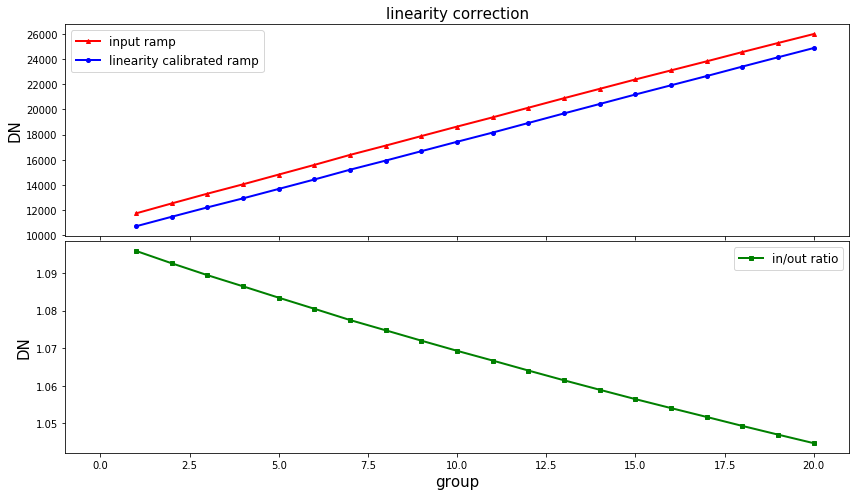

In [4]:
# set the sample pixel
pixel = [600,500]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# open the input file as a datamodel
in_dm = datamodels.open(my_input_file)

# plot
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=4, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', markersize=4, 
            linestyle='-', linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] / dm.data[0,:,pixel[1],pixel[0]], c='g', 
            marker='s', markersize=4, linestyle='-', linewidth=2, label='in/out ratio')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



We can also plot the pixels that have been flagged in PIXELDQ where there is no valid linearity correction

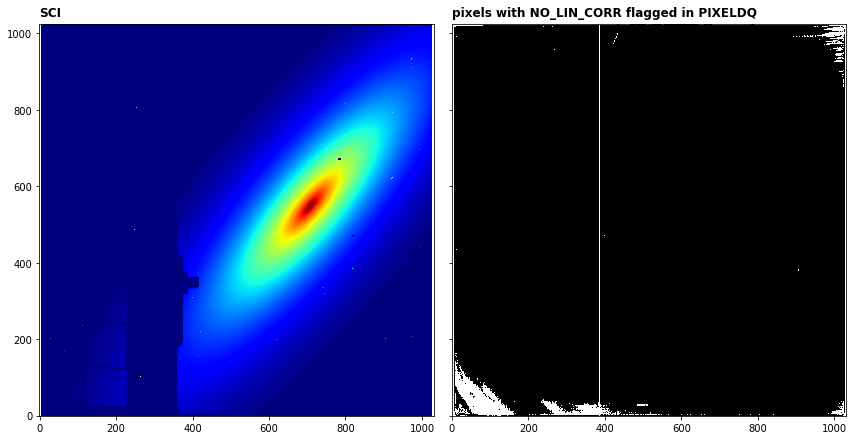

In [5]:
# plot the science and pixeldq array where NO_LIN_CORR set
fig, axs = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.1e4,vmax=6.5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# NO_LIN_CORR is assigned the flag 1048576, values will be larger or equal
no_lin_cor = dm.pixeldq >= 1048576
no_lin_cor.astype(np.int)
axs[1].imshow(no_lin_cor, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('pixels with NO_LIN_CORR flagged in PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `LinearityStep` class using the `strun` command:

```bash
strun jwst.linearity.LinearityStep det_image_seq1_MIRIMAGE_F1130Wexp1_lastframestep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `LinearityStep` using the `strun` command with the associated `linearity.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/linearity.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_lastframestep.fits
```

This will produce the same output file ending with `_linearitystep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.linearity.LinearityStep -h
```

or 

```bash
strun cfgs/linearity.cfg -h
```


### Override reference file

To override the reference file for this step in Python:

```python
# set the override reference file name
my_ref = 'my_lin.fits'

dm = linearity.LinearityStep.call(my_input_file, output_use_model=True, save_results=True,
                                    override_linearity=my_ref)
```

and using the command line:

```bash
strun jwst.linearity.LinearityStep det_image_seq1_MIRIMAGE_F1130Wexp1_lastframestep.fits  --override_linearity my_lin.fits
```

or

```bash
strun cfgs/linearity.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_lastframestep.fits --override_linearity my_lin.fits
```